In [2]:
%load_ext autoreload
%autoreload 2

In [1]:
import numpy as np
import torch
import copy
from torch.nn.modules import Module
from torch import Tensor
from torch import nn as nn
import math
from transformers import BertForSequenceClassification, BertTokenizer, AutoTokenizer, AutoModelForPreTraining
from symb_xai.model.transformer import tiny_transformer_with_3_layers
from symb_xai.model.utils import load_pretrained_weights

from IPython.display import display, HTML
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
from scipy import stats as st
from datasets import load_dataset
from itertools import product
import dgl
import networkx as nx

/opt/miniconda3/envs/symb_xai/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Visualization Code

In [3]:
from symb_xai.visualization.utils import rescale_score_by_abs, getRGB, span_word, html_heatmap, \
make_text_string, make_color, vis_tree_heat


## XAI Utils

In [4]:
# from explanation import symb_xai, lrp, HOExplainer

In [5]:
from symb_xai.lrp.symbolic_xai import TransformerSymbXAI


## BERT model with 3 layers

In [6]:
# Create model.
model = tiny_transformer_with_3_layers(
    pretrained_model_name_or_path="textattack/bert-base-uncased-SST-2"
)
pretrained_embeddings = model.bert.embeddings

# Load pre-trained weights.
load_pretrained_weights(
    model,
    '../saved_models/sst2-3layer-model.pt'
)


## Explain tiny BERT model on the SST2 dataset

In [7]:
from dgl.data import SSTDataset

mode =  'treebank' # 'treebank' 
if mode == 'huggingface':
    # Load SST2 dataset.
    dataset = load_dataset("sst2", "default")
if mode == 'treebank':
    dataset = SSTDataset(mode='train')
    vocab_words = list(dataset.vocab.keys())


In [8]:
def process_treeid2tokenid(indices, mask, tokens, lsent, verbose=False):
    assert len(mask.nonzero()) == len(lsent), f'len(mask.nonzero()) = {len(mask.nonzero())} != {len(lsent)} = len(indices) '
    cls_id = 0
    sep_id = len(tokens)-1
    
    wordInd2token = {}
    curr_tid = 1 # start with the first token
    for word_tid in range(len(lsent)):
        if tokens[curr_tid] == lsent[word_tid]: 
            wordInd2token[word_tid] = [curr_tid]
            curr_tid += 1
            continue
        else:
            word_string = tokens[curr_tid].replace('##', '')
            tids = [curr_tid]
            while word_string != lsent[word_tid]:
                curr_tid += 1
                word_string += tokens[curr_tid].replace('##', '')
                tids.append(curr_tid)
                if curr_tid == sep_id : 
                    raise RuntimeError(f'Not possible to parse {tokens} into {lsent}')
            
            wordInd2token[word_tid] = tids
            curr_tid += 1
        
    if verbose: print(wordInd2token)
        
    token_indices = []
    for ind in indices:
        word_ids = list(mask.nonzero().squeeze().numpy())
        if ind in word_ids:
            token_indices += wordInd2token[word_ids.index(ind)]
    
    return token_indices

# Plot a few data samples

In [33]:
import dgl
import matplotlib.pyplot as plt
import networkx as nx
from networkx.drawing.nx_pydot import graphviz_layout
from symb_xai.visualization.utils import make_color


tokenizer = BertTokenizer.from_pretrained("textattack/bert-base-uncased-SST-2")
embeddings = model.bert.embeddings

label2sent_symb = {0:'- -', 1: '-', 2:'0', 3: '+', 4:'++'}


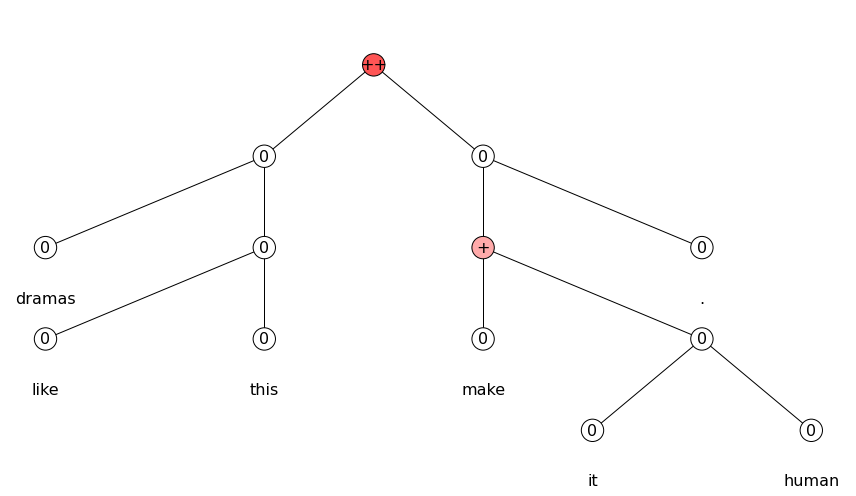

In [43]:
# plot ground truth
sid = 12
tree = dataset[sid]
input_ids = tree.ndata['x'] # word id of the node
labels = tree.ndata['y'] #  label of the node
mask = tree.ndata['mask']
lsent =  [vocab_words[idw] for idw in input_ids[mask == 1]]
sentence =  make_text_string(lsent)
sample = tokenizer(sentence, return_tensors="pt")
words = tokenizer.convert_ids_to_tokens(sample['input_ids'].squeeze())
    


node_labels = {i:label2sent_symb[int(label)] for i,label in enumerate(labels)}

node_heat = [make_color( (float(label) - 2.)/3.) for label in labels]

vis_tree_heat(tree, node_heat, vocab_words, node_labels=node_labels, 
              save_dir=None, #f'pics/sample{sid}_ground_truth.png',
             word_dist=40,
             node_size=500)


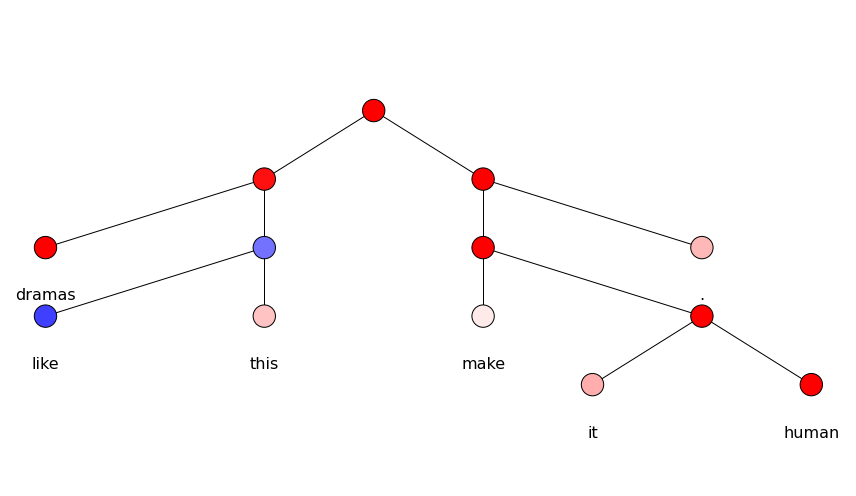

In [47]:
from symb_xai.lrp.queries import Mode
# plot relevance

mode = Mode.OR


target = torch.tensor([-1,1])

explainer = TransformerSymbXAI(sample, target, model, embeddings)


G = dgl.to_networkx(tree)
node_rels = {}
node_labels = {}

for node_id in range(len(labels)):
    ances = nx.ancestors(G, node_id)
    ances.add(node_id)
    
    token_set = process_treeid2tokenid(ances, mask, words, lsent, verbose=False)
    
    if mode == Mode.OR:
        node_rels[node_id] = explainer.symb_or(token_set).item()
    if mode == Mode.SUBSET:
        node_rels[node_id] = explainer.subgraph_relevance(token_set).item()
    
#     node_labels[node_id] = [explainer.words[token] for token in token_set]
    
node_heat = [make_color( rel, scaling=1) for rel in node_rels.values() ]
# node_labels = {i:round(rel,3) for i,rel in enumerate(node_rels.values()) }
node_labels = {i:round(rel,2) for i,rel in enumerate(node_rels.values()) }


vis_tree_heat(tree, 
              node_heat, 
              vocab_words,
#               node_labels=node_labels, 
              save_dir=None, #f'pics/sample{sid}_contr_{mode}.png',
             node_size=500)
# print(node_rels)

# Analyse how the explanation method aligns with the human annotation

In [84]:
idrange = range(200)
mode = Mode.SUBSET
verbose = True

all_contr = {i: [] for i in range(5)}

for sid in idrange:
    tree = dataset[sid]
    input_ids = tree.ndata['x'] # word id of the node
    labels = tree.ndata['y'] #  label of the node
    mask = tree.ndata['mask']
    lsent =  [vocab_words[idw] for idw in input_ids[mask == 1]]
    sentence =  make_text_string(lsent)
    sample = tokenizer(sentence, return_tensors="pt")
    words = tokenizer.convert_ids_to_tokens(sample['input_ids'].squeeze())

    

    target = torch.tensor([-1,1])

    explainer = TransformerSymbXAI(sample, target, model, embeddings)

    G = dgl.to_networkx(tree)
    node_rels = {}
    try:
        for node_id in range(len(labels)):
            ances = nx.ancestors(G, node_id)
            ances.add(node_id)

            token_set = process_treeid2tokenid(ances, mask, words, lsent, verbose=False)

            if mode == Mode.OR:
                node_rels[node_id] = explainer.symb_or(token_set).item()
            if mode == Mode.SUBSET:
                node_rels[node_id] = explainer.subgraph_relevance(token_set).item()
    except RuntimeError:
        if verbose: print(f'skip {sid}')
        continue
    node_labels = {i: int(label) for i,label in enumerate(labels)}
    
    assert len(node_labels.values()) == len(node_rels.values())
    
    for label, rel in zip(node_labels.values(), node_rels.values()):
        all_contr[label].append(rel)
    
#     node_heat = [make_color( rel, scaling=1) for rel in node_rels.values() ]


skip 18
skip 29
skip 40
skip 50
skip 93
skip 94
skip 95
skip 103
skip 137
skip 149
skip 151
skip 180
skip 188
skip 192


INFO:matplotlib.mathtext:Substituting symbol R from STIXNonUnicode
INFO:matplotlib.mathtext:Substituting symbol R from STIXNonUnicode


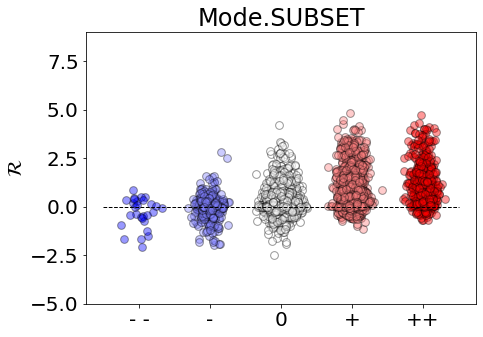

In [85]:
plt.figure(figsize=(7,5))
plt.rcParams.update({'font.size': 20})

for label, rels in all_contr.items():
    x = np.random.normal(loc=label, scale=.1, size=len(rels))
    plt.scatter(x,rels,
                alpha=.4, 
                edgecolors='black', 
                color = make_color(label-2, scaling=.5),
               s=60)
plt.hlines(y=0,xmin=-.5, xmax=4.5, color='black', ls='--', linewidth=1)
plt.xticks(list(label2sent_symb.keys()), list(label2sent_symb.values()))
plt.ylabel('$\\mathcal{R}$')
plt.ylim(-5,9)
plt.title(mode)
plt.show()